In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.features import pca_decomposition
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linreg_diag import *

plt.rcParams['figure.dpi'] = 300
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['axes.facecolor'] = 'white'  # Set background color to white
plt.rcParams['axes.grid'] = False  # Disable grid lines

## Exploratory Data Analysis

In [3]:
# Load the dataset directly from the GitHub URL
url = "data/insurance.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataframe
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [20]:
df['sex'] = pd.Categorical(df['sex'])
df['smoker'] = pd.Categorical(df['smoker'])
df['region'] = pd.Categorical(df['region'])

# Verify the changes
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


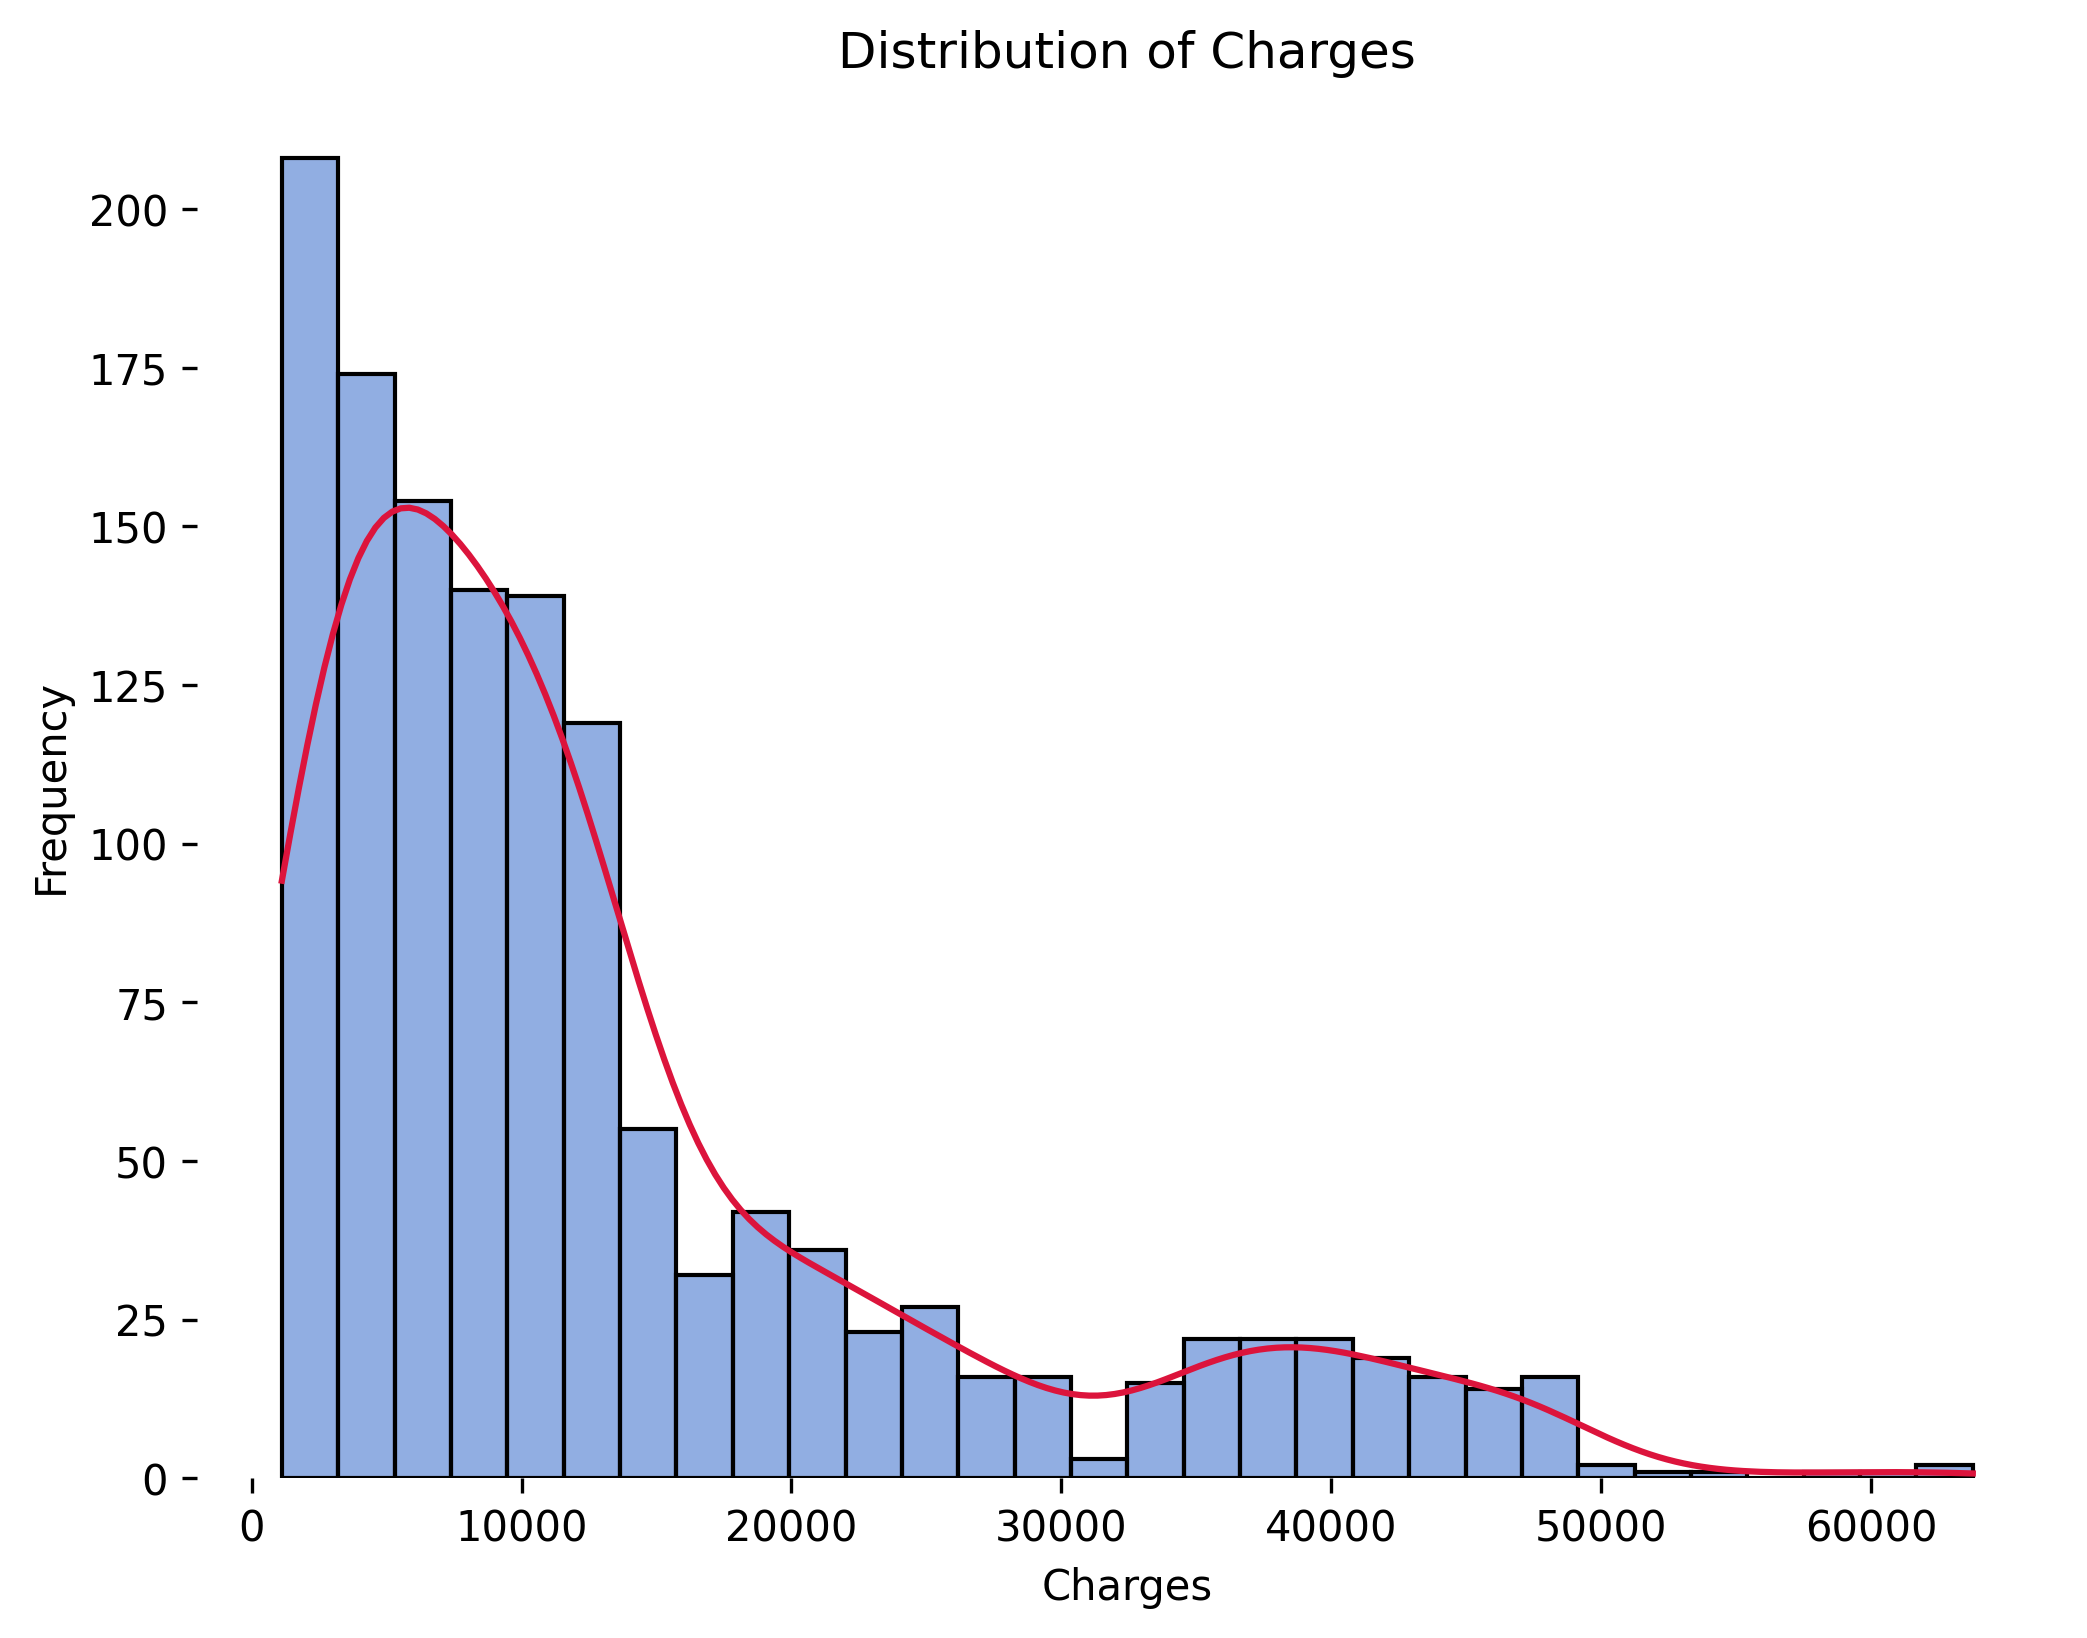

In [21]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram and KDE
sns.histplot(df, x='charges', kde=True, alpha=0.6)
ax.lines[0].set_color('crimson')

# Set the title, labels, and spines
ax.set_title('Distribution of Charges')
ax.set_xlabel('Charges')
ax.set_ylabel('Frequency')
sns.despine(left=True, bottom=True, right=True, top=True, ax=ax)  # Specify the axes for despine

# Show the plot
plt.show()

In [22]:
print(f"The insurance charges skewness is:", df['charges'].skew())

The insurance charges skewness is: 1.5158796580240388


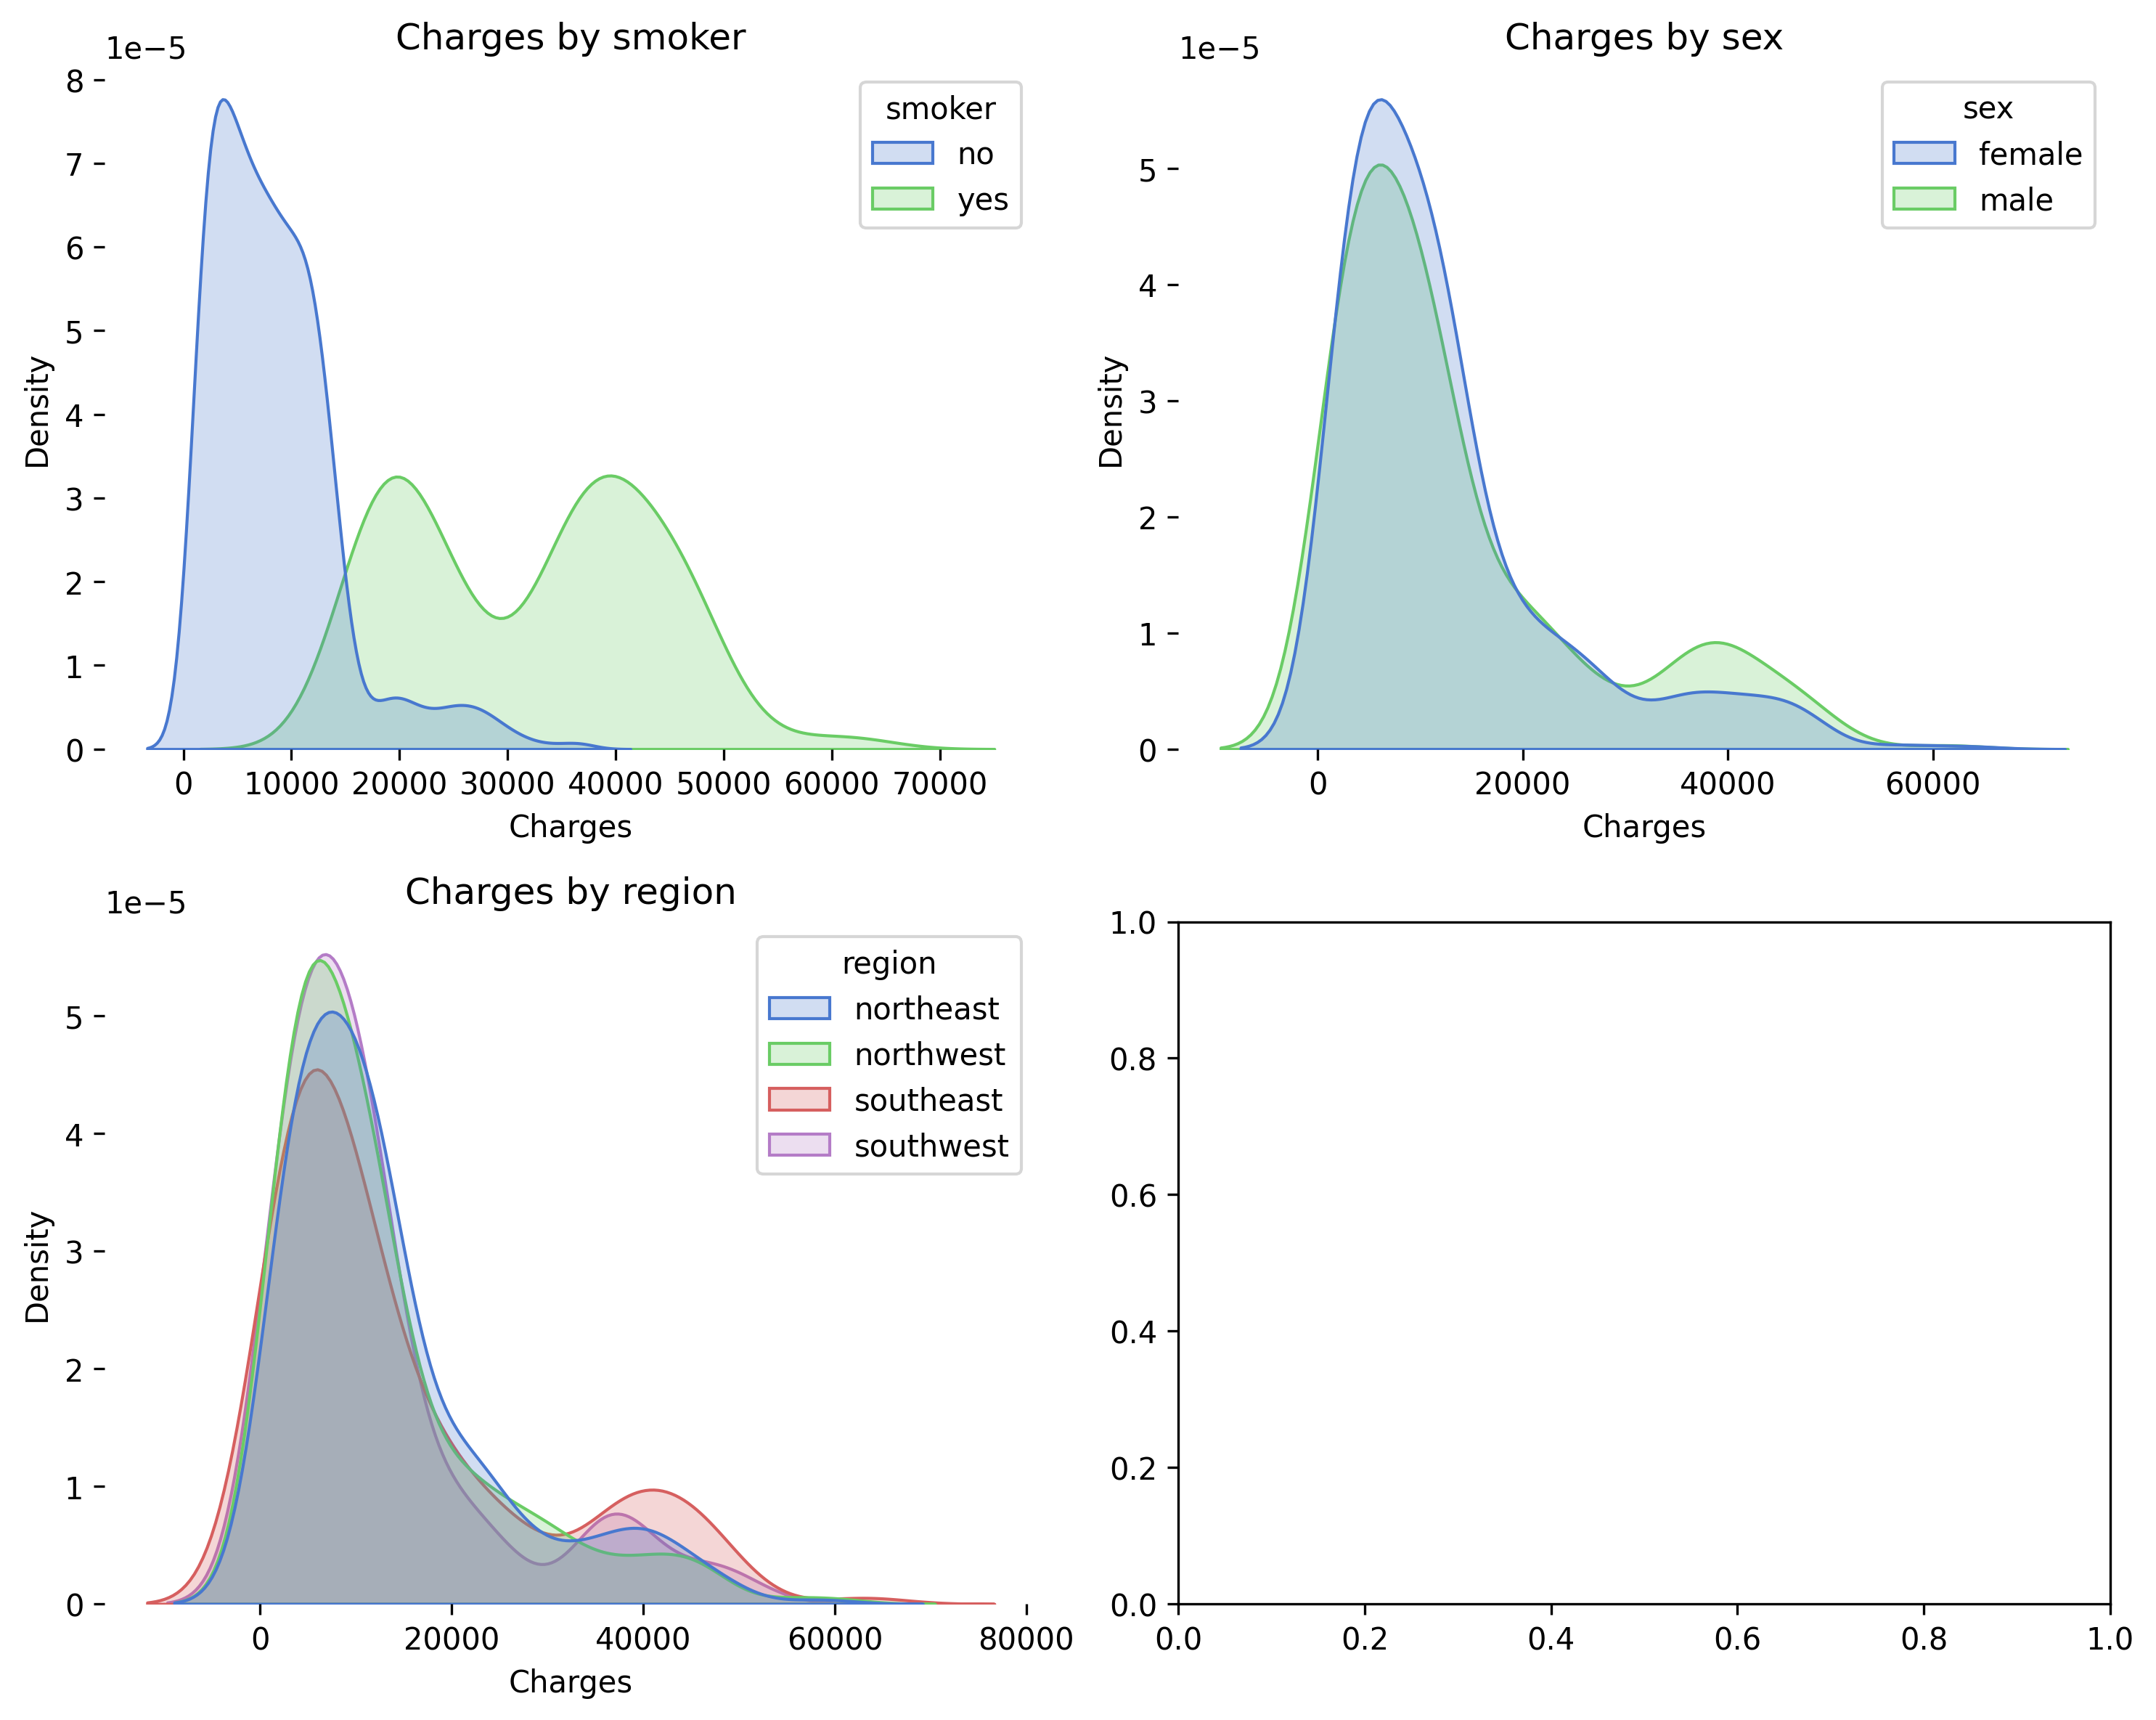

In [23]:
# Create the figure and axes with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define the hue variables for each subplot
hue_vars = ['smoker', 'sex', 'region']

# Iterate through the hue variables and create KDE plots
for i, hue in enumerate(hue_vars):
    sns.kdeplot(data=df, x='charges', hue=hue, fill=True, ax=axes[i], common_norm=False)
    axes[i].set_title(f'Charges by {hue}')
    axes[i].set_xlabel('Charges')
    axes[i].set_ylabel('Density')
    sns.despine(left=True, bottom=True, right=True, top=True, ax=axes[i])


# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


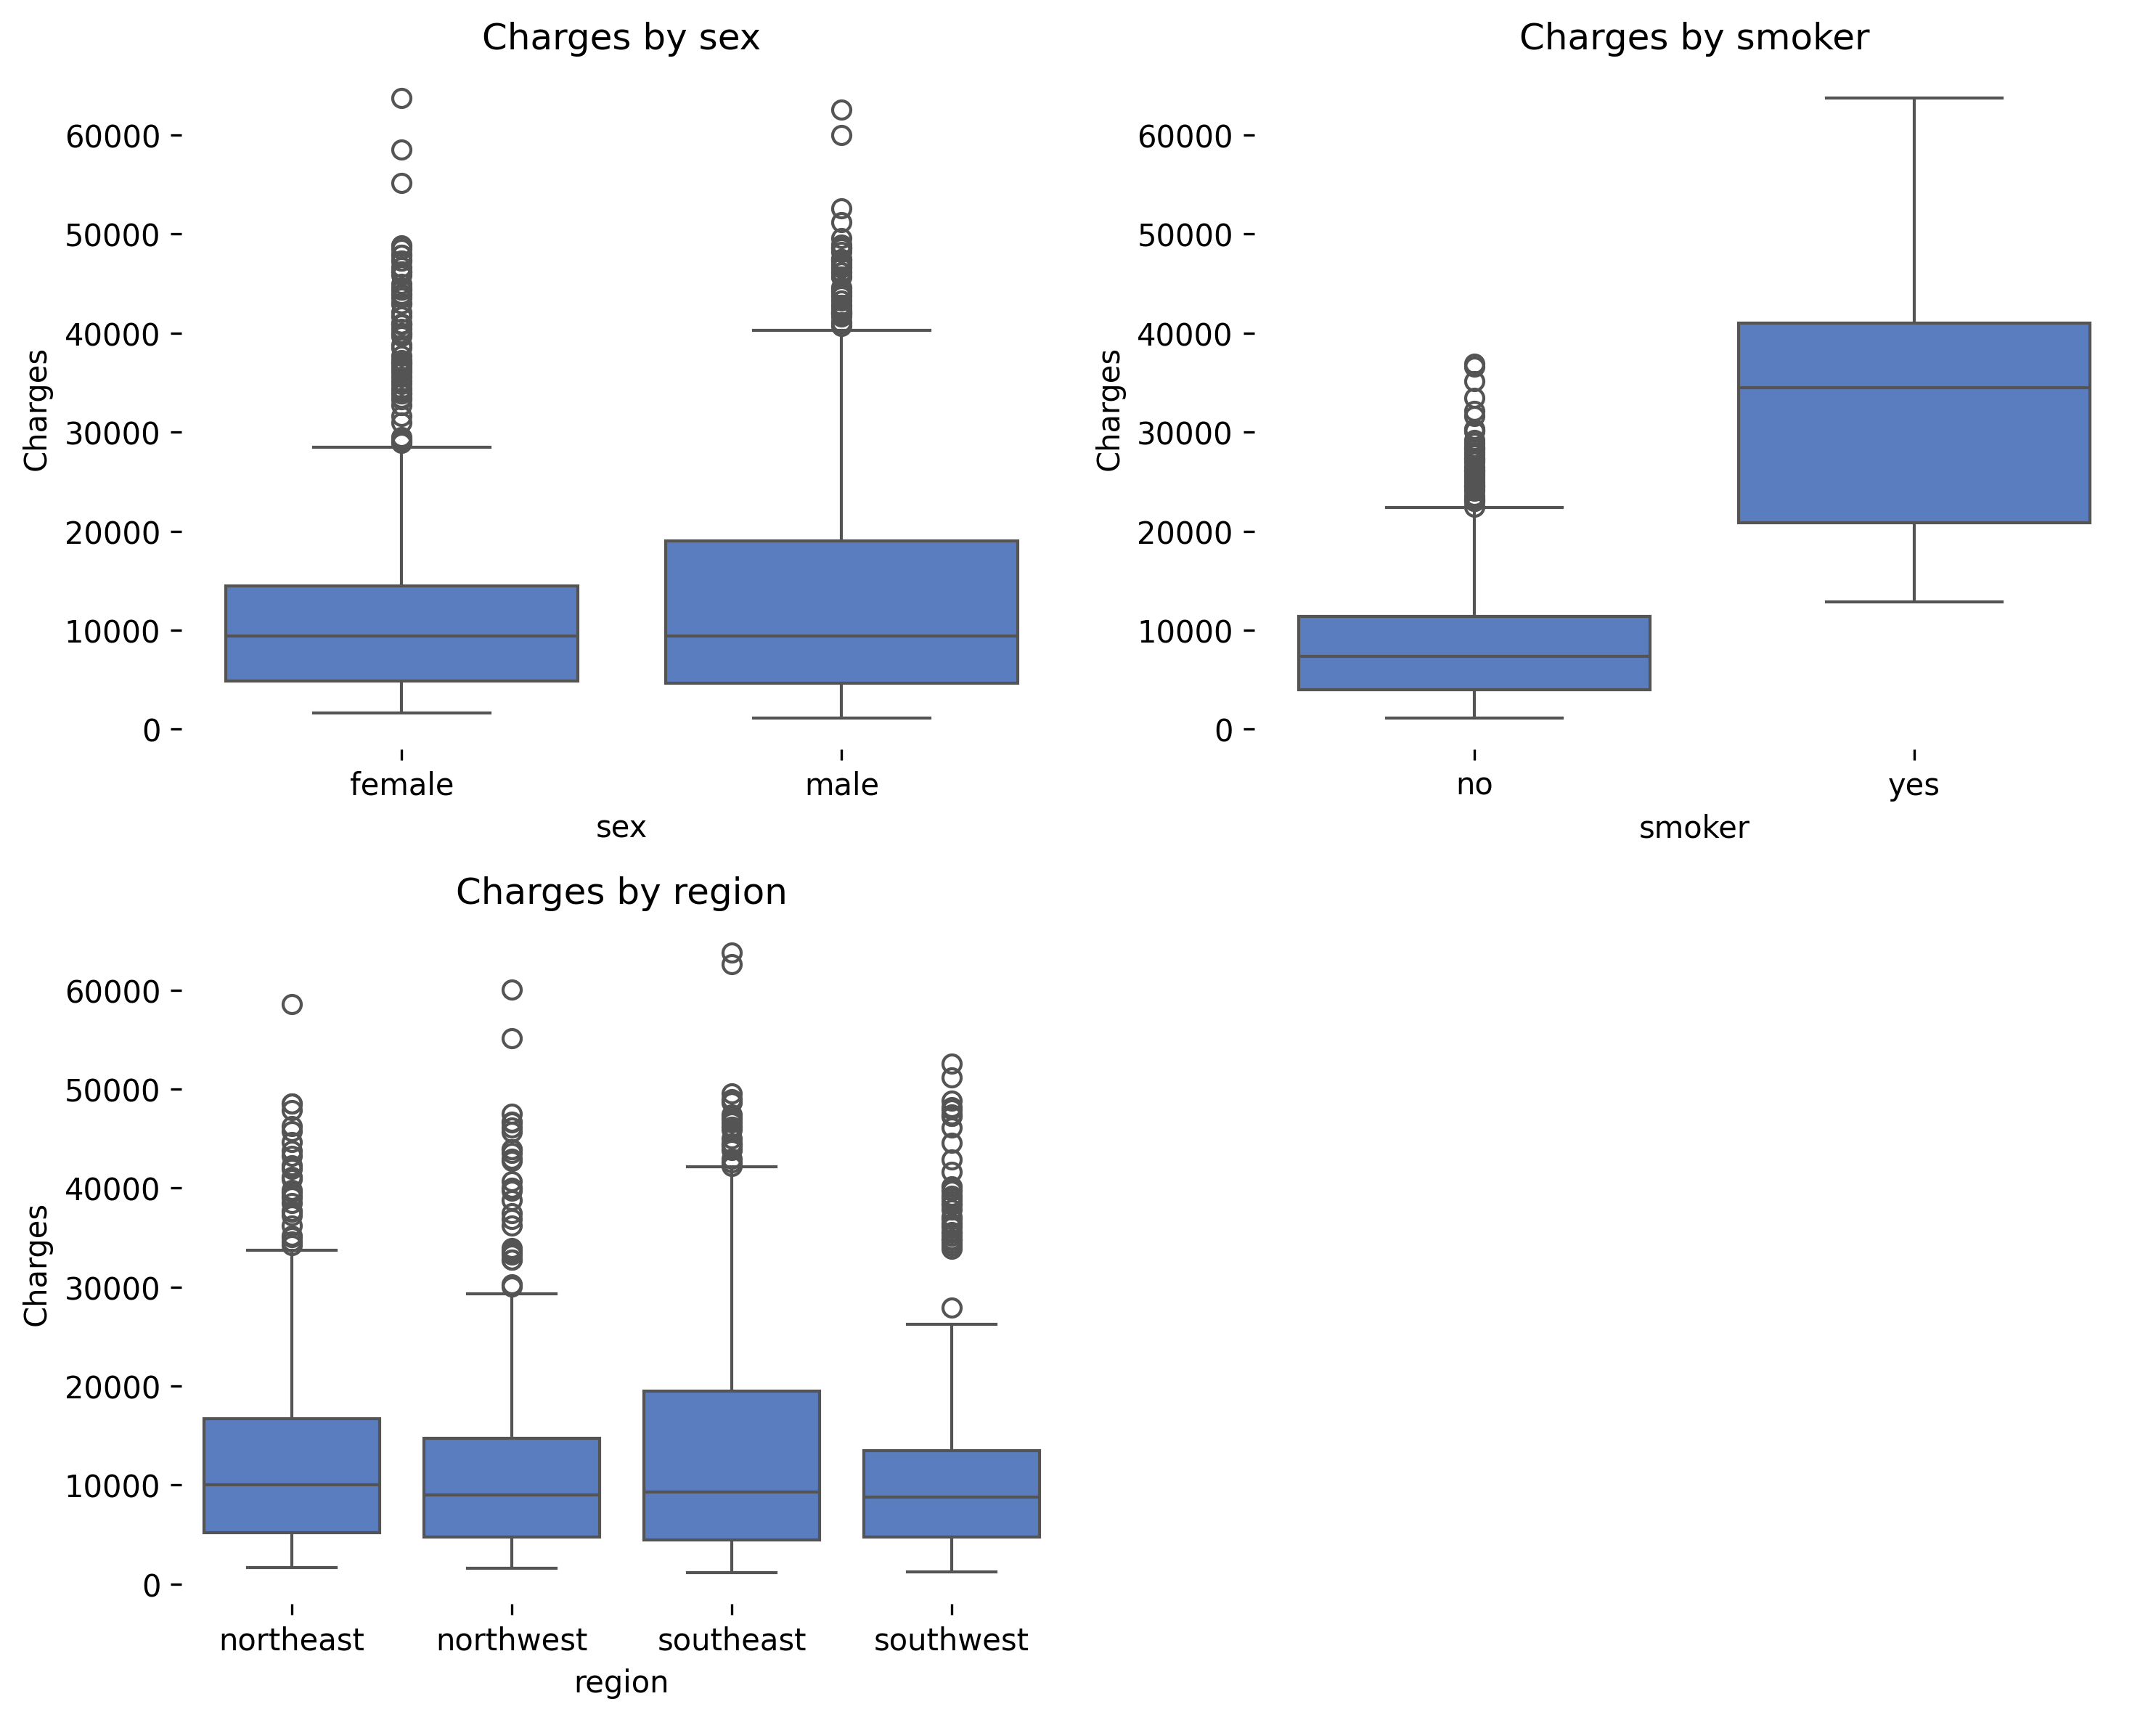

In [24]:
# Create a figure with subplots for each categorical variable in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# List of categorical variables to plot
categorical_vars = ['sex', 'smoker', 'region']

# Iterate through the categorical variables and create box plots
for i, var in enumerate(categorical_vars):
    sns.boxplot(data=df, x=var, y='charges', ax=axes[i])
    axes[i].set_title(f'Charges by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Charges')
    sns.despine(left=True, bottom=True, right=True, top=True, ax=axes[i])

# Hide the unused subplot if there are less than 4 variables
if len(categorical_vars) < 4:
    for j in range(len(categorical_vars), 4):
        fig.delaxes(axes[j])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

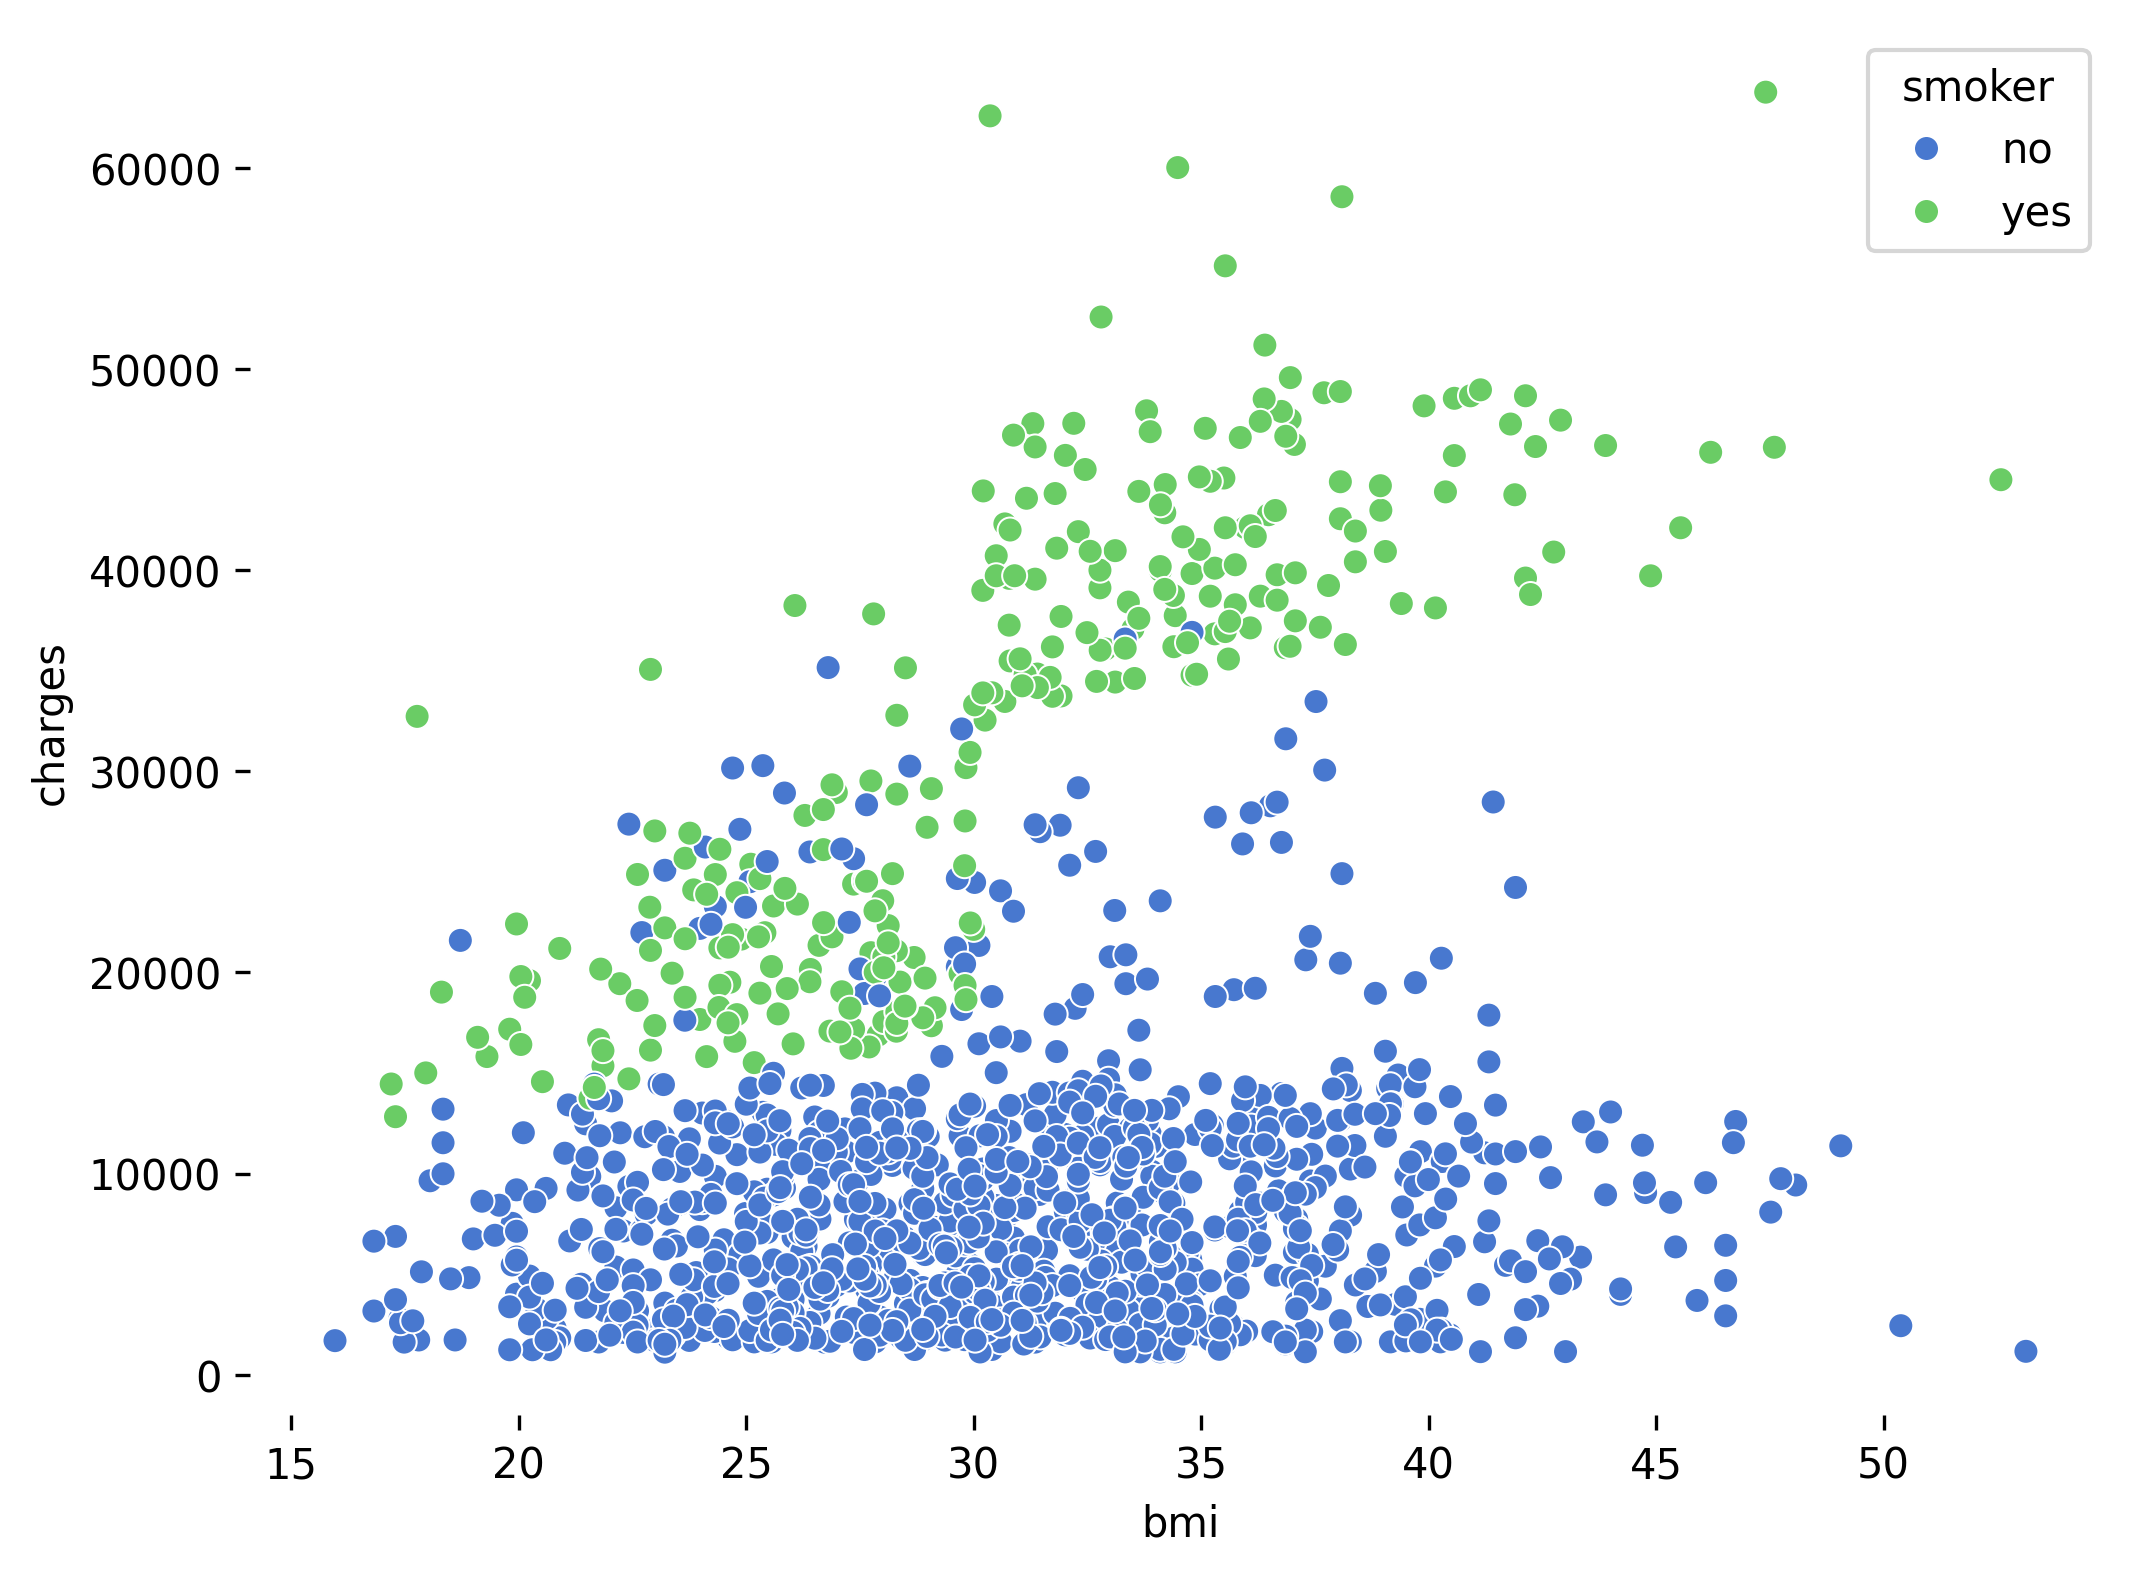

In [25]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')
sns.despine(left=True, bottom=True, right=True, top=True)
plt.show()


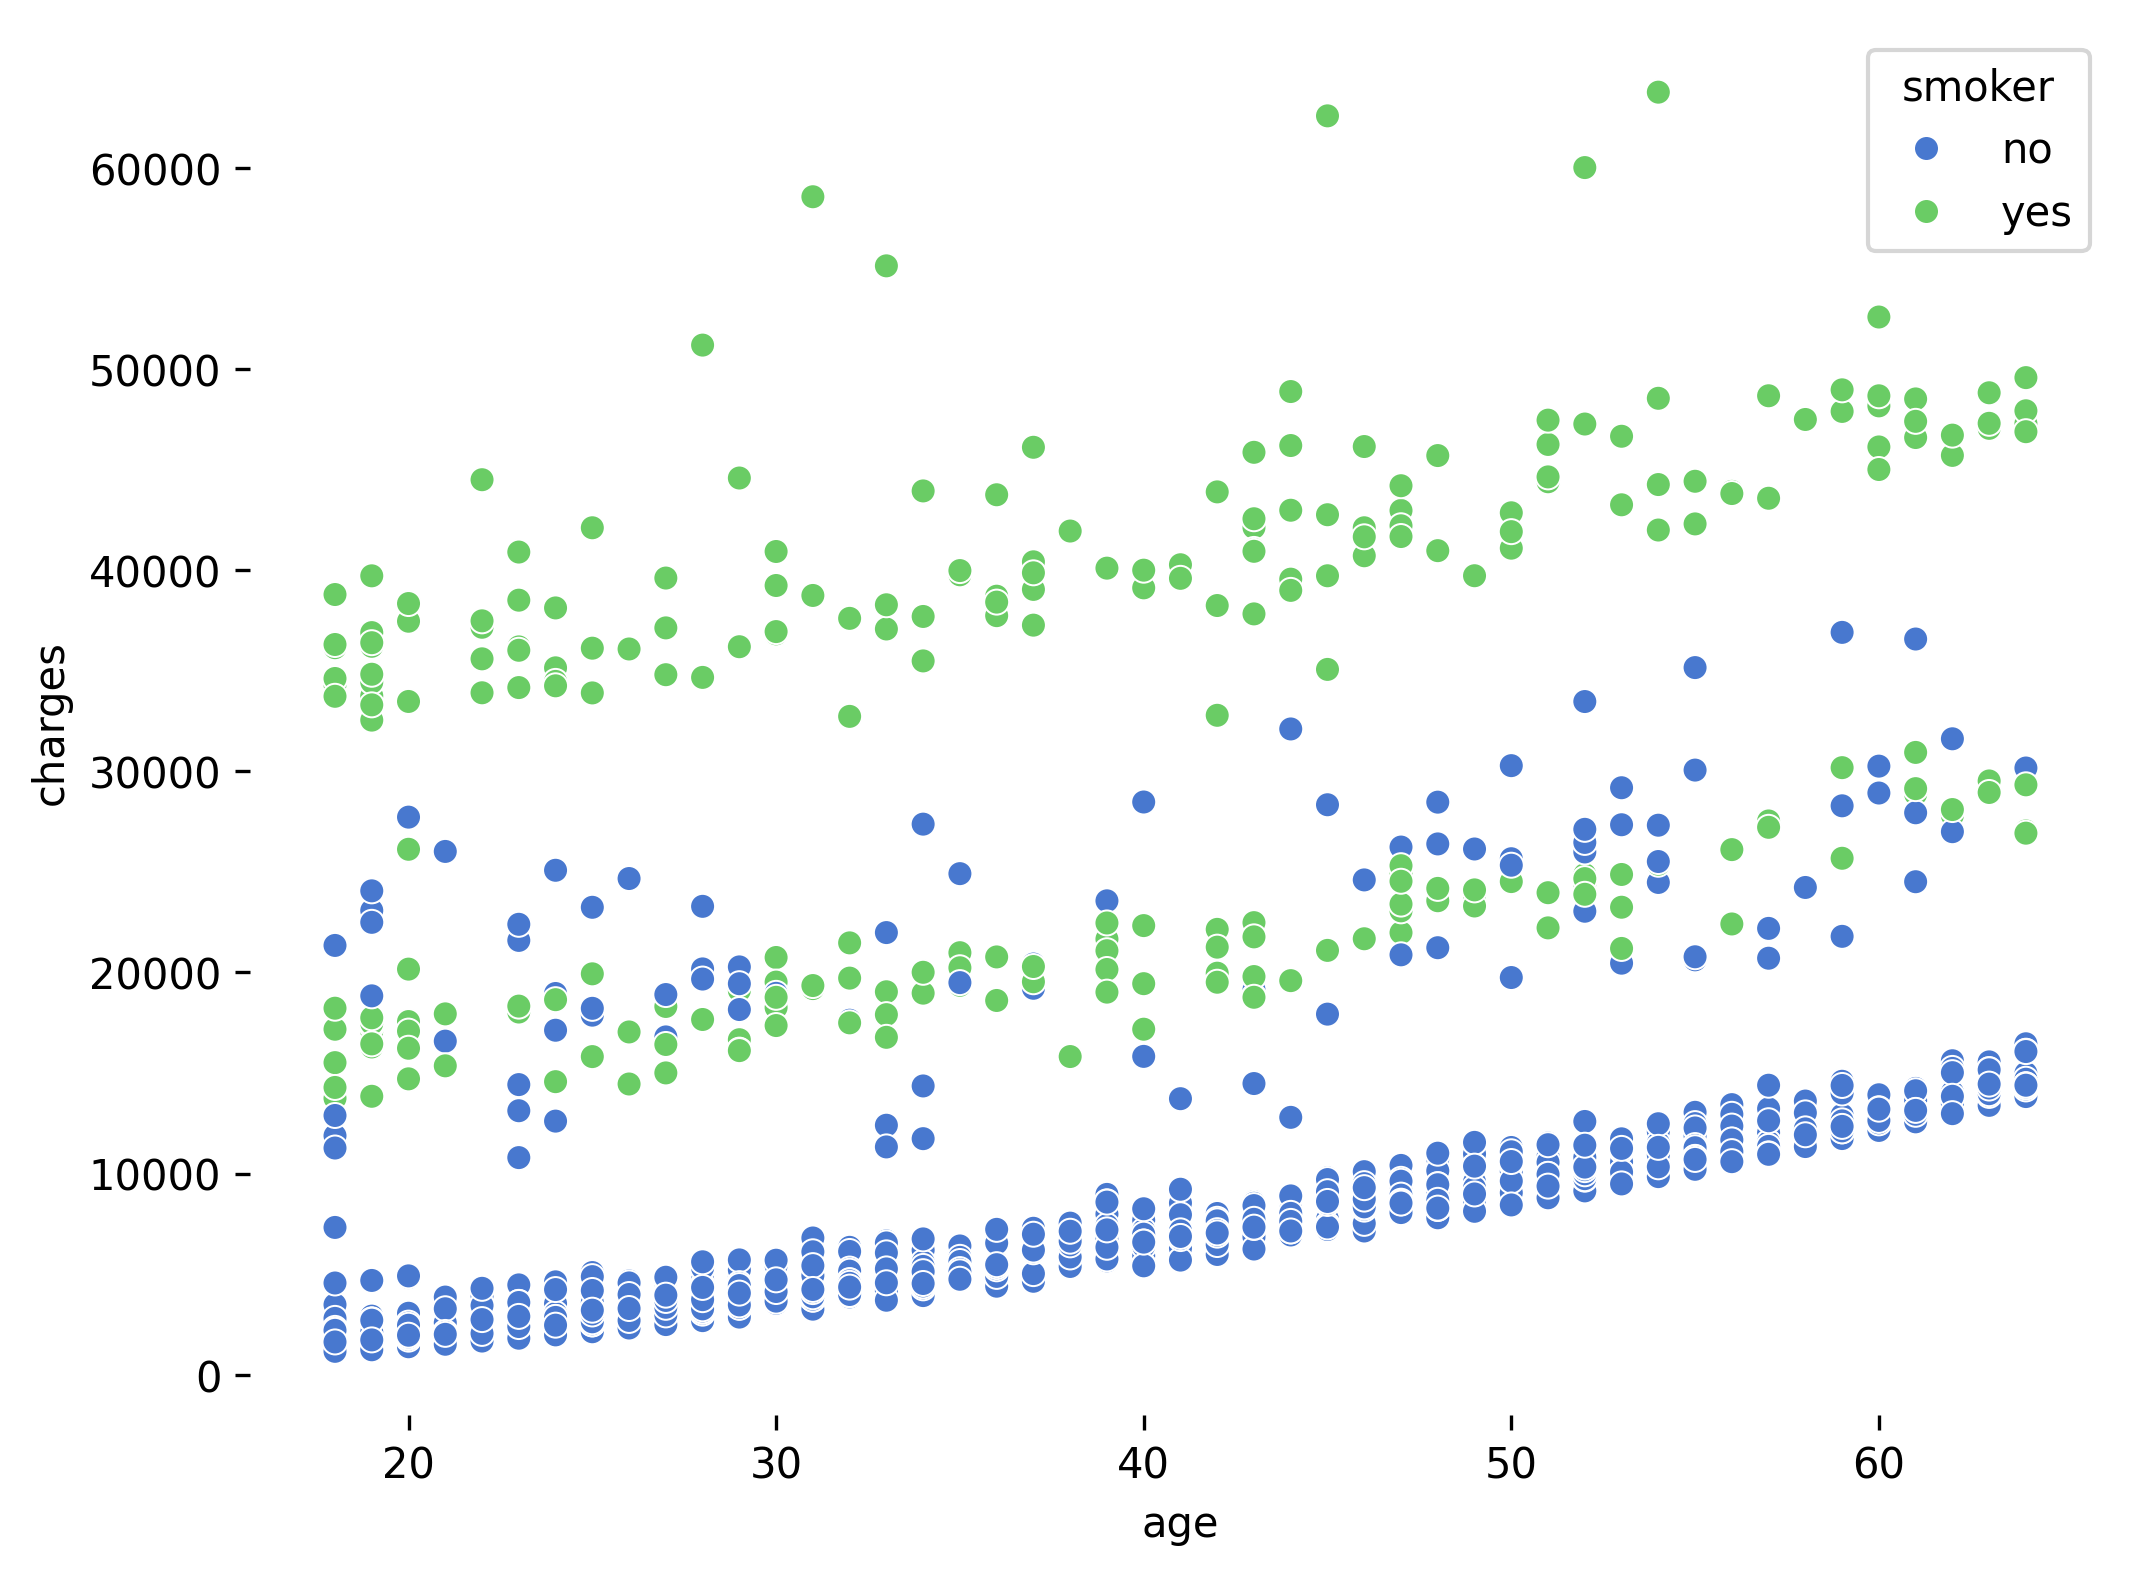

In [26]:
# Create the scatter plot with point size modified by BMI
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='age', y='charges', hue='smoker') # Adjust sizes as needed
sns.despine(left=True, bottom=True, right=True, top=True)
plt.show()


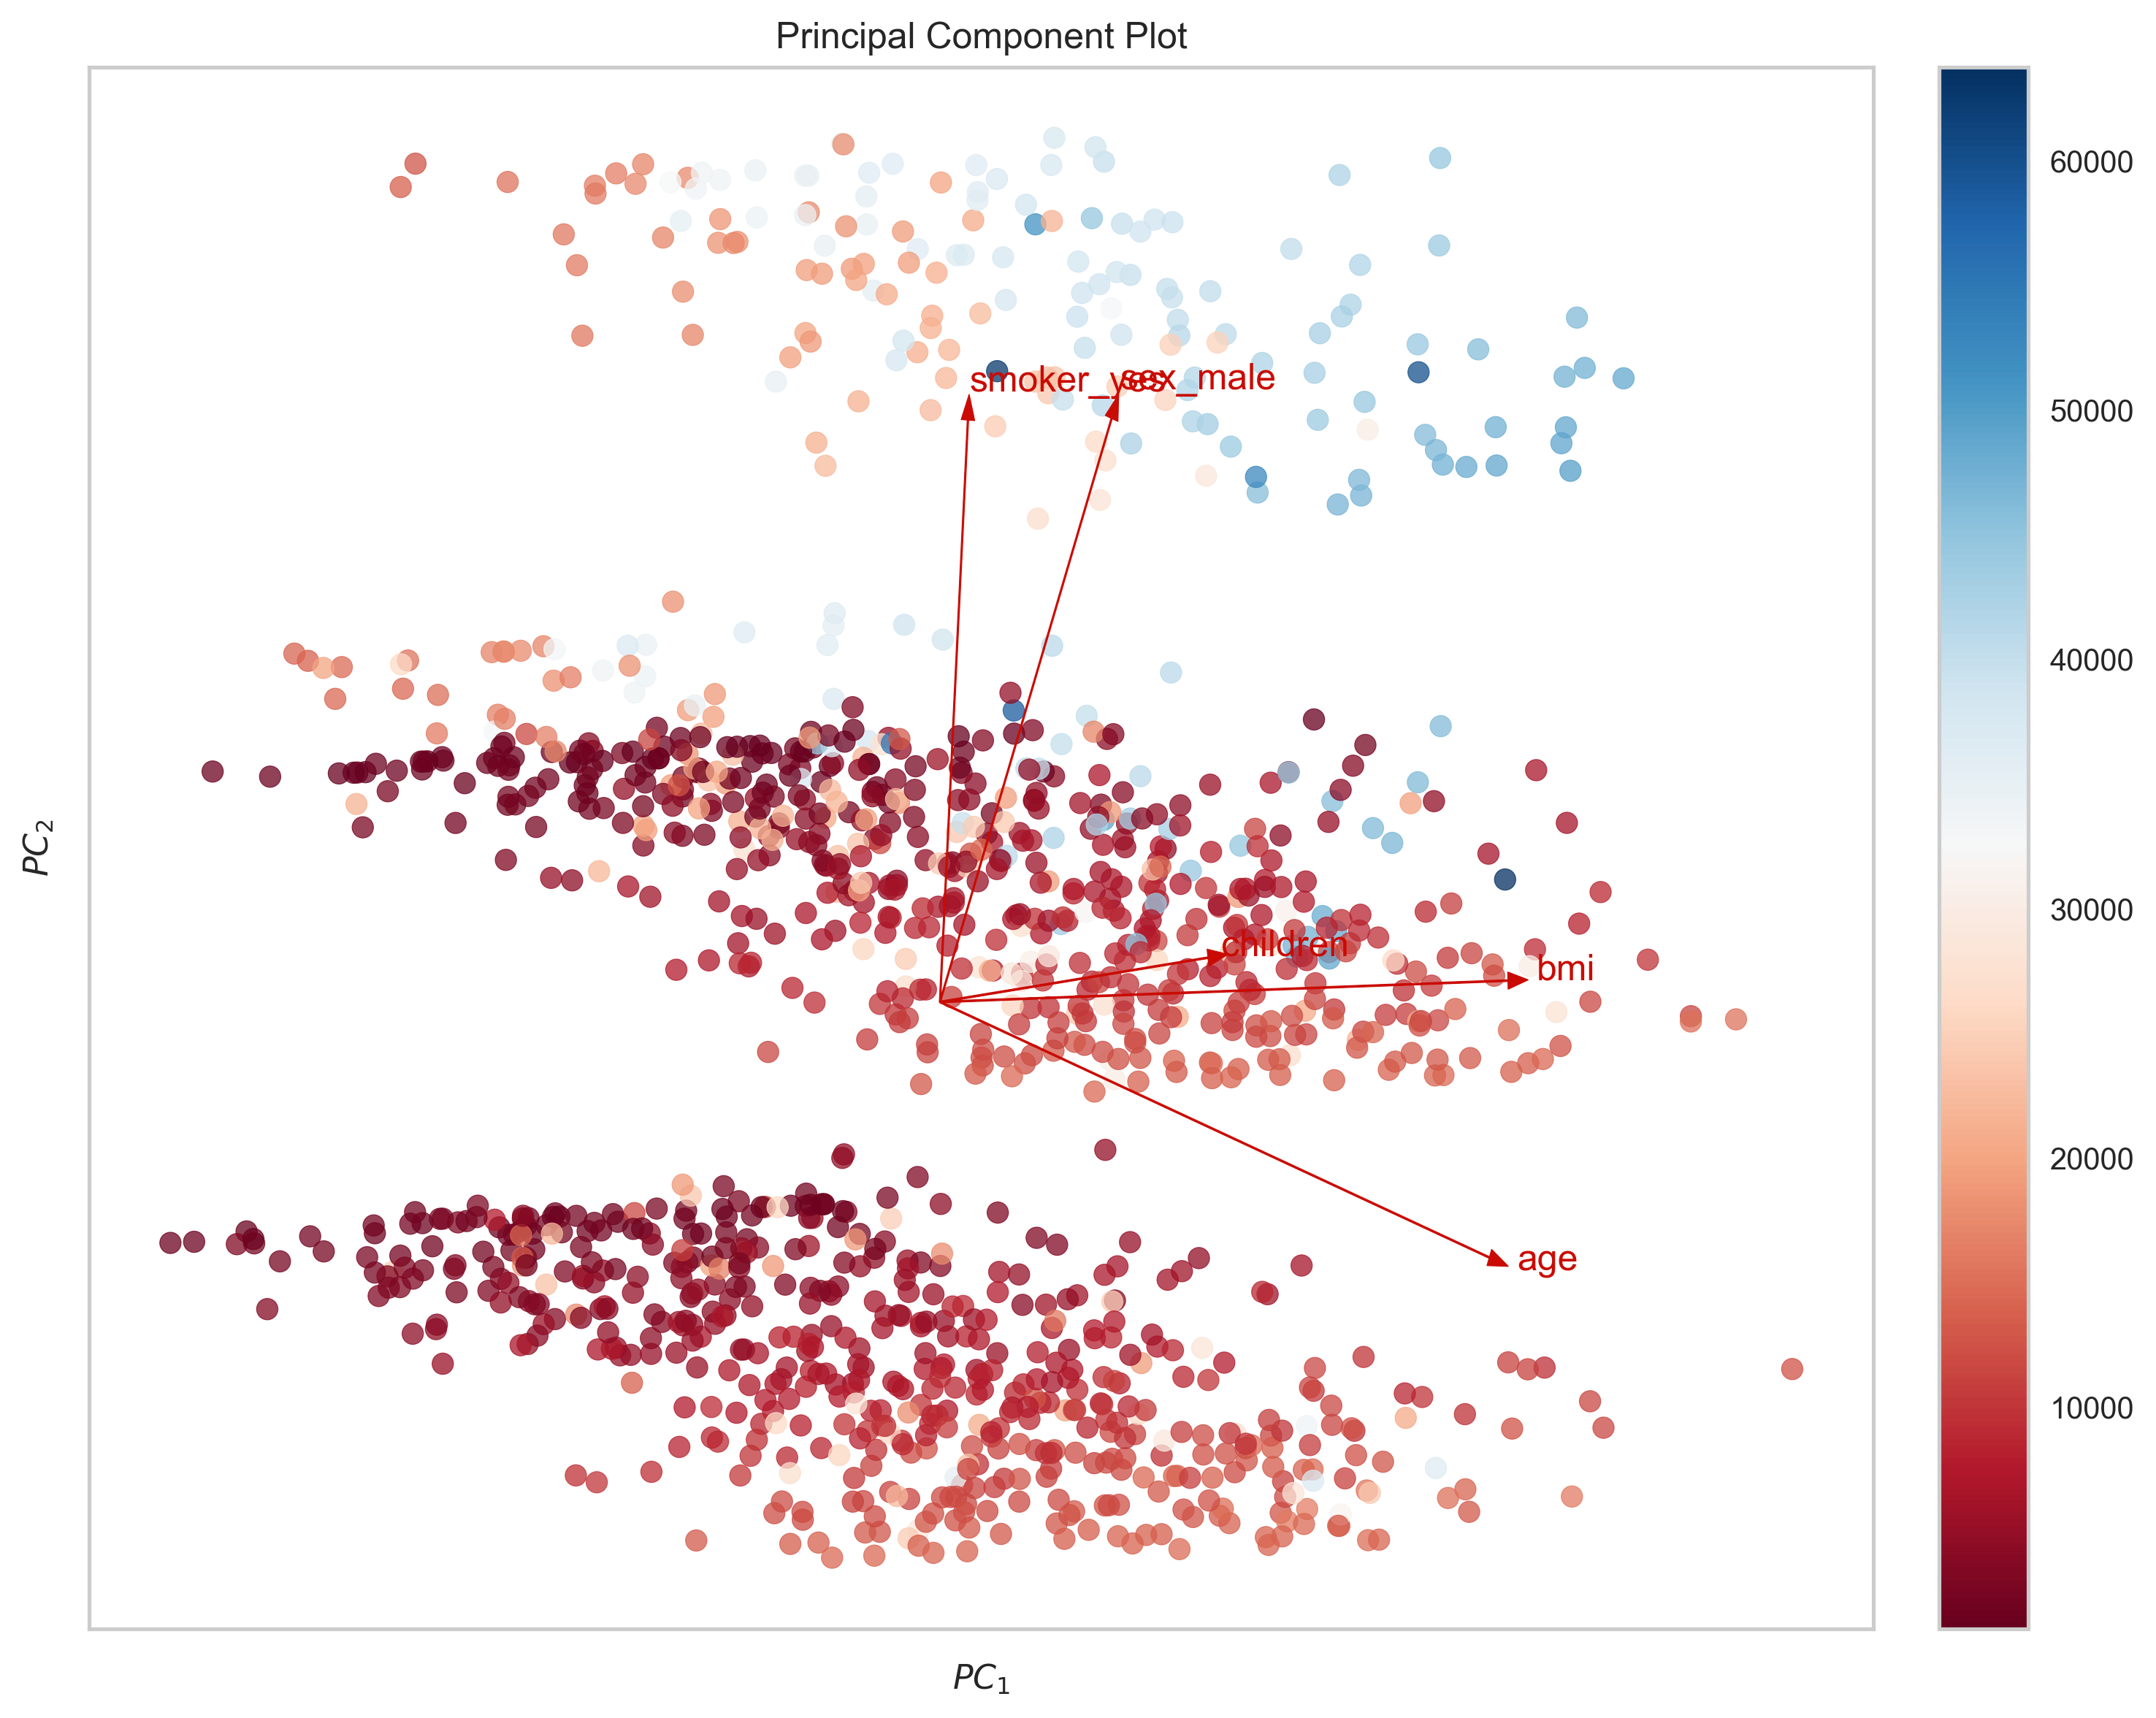

In [15]:
# One-hot encode 'sex' and 'smoker', drop first to avoid multicollinearity
df_encoded = pd.get_dummies(df[['age', 'bmi', 'children', 'sex', 'smoker']], drop_first=True)

y = df['charges']
X = df_encoded

fig, ax = plt.subplots(figsize = (10, 8))

pca_decomposition(X, y, scale = True,
                  proj_features = True, ax = ax)
plt.show()

## Regression Analysis

In [37]:
# Log transform 'charges'
df['charges_log'] = np.log10(df['charges'])


# Fit linear regression model using formula syntax with explicit categorical variables and interaction terms
model = smf.ols(
    formula="charges ~ age + bmi + C(sex) + C(smoker) + C(region) + children + bmi:C(smoker) + age:C(smoker) + age:bmi",
    data=df
)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     638.1
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        21:06:45   Log-Likelihood:                -13247.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1326   BIC:                         2.658e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 50